<a href="https://colab.research.google.com/github/VayuSarangam/quant-finance-portfolio/blob/main/portfolio-optimization/Portfolio_Optimization_MeanVariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [1]:
!pip -q install yfinance scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from scipy.optimize import minimize


Pull data - Use liquid tickers (avoid penny stocks). Start with 6–10.

In [2]:
tickers = ["SPY", "QQQ", "IWM", "EFA", "TLT", "GLD"]  # ETF set keeps it clean (Why ETFs: stable data, less missing values, clean signal)
start = "2018-01-01"
end = None  # up to today

prices = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
prices = prices.dropna()
prices.tail()


[*********************100%***********************]  6 of 6 completed


Ticker,EFA,GLD,IWM,QQQ,SPY,TLT
Date,,,,,,
2026-02-04,101.779999,453.970001,260.519989,605.750000,686.190002,86.540001
2026-02-05,100.330002,441.880005,255.830002,597.030029,677.619995,87.480003
2026-02-06,102.610001,455.459991,265.019989,609.650024,690.619995,87.540001
2026-02-09,103.989998,467.029999,266.880005,614.320007,693.950012,87.519997
2026-02-10,104.239998,462.399994,266.160004,611.469971,692.119995,88.529999


Returns + annualization

In [3]:
# Daily log returns
rets = np.log(prices / prices.shift(1)).dropna()

# Annualize
trading_days = 252
mu = rets.mean() * trading_days                  # expected annual return vector
cov = rets.cov() * trading_days                  # annual covariance matrix

mu, cov.head()


(Ticker
 EFA    0.077747
 GLD    0.161680
 IWM    0.080249
 QQQ    0.173504
 SPY    0.132473
 TLT   -0.015306
 dtype: float64,
 Ticker       EFA       GLD       IWM       QQQ       SPY       TLT
 Ticker                                                            
 EFA     0.032444  0.006085  0.035855  0.032934  0.029970 -0.003106
 GLD     0.006085  0.025783  0.004077  0.003875  0.002837  0.005930
 IWM     0.035855  0.004077  0.060738  0.045630  0.041585 -0.004661
 QQQ     0.032934  0.003875  0.045630  0.057589  0.043695 -0.003778
 SPY     0.029970  0.002837  0.041585  0.043695  0.037720 -0.004529)

Helper functions

In [5]:
def portfolio_return(w, mu):
    return np.dot(w, mu)

def portfolio_vol(w, cov):
    return np.sqrt(np.dot(w, np.dot(cov, w)))

def neg_sharpe(w, mu, cov, rf=0.02):
    r = portfolio_return(w, mu)
    v = portfolio_vol(w, cov)
    return -(r - rf) / v

def weight_sum_constraint(w):
    return np.sum(w) - 1.0


Constraints + bounds (Long-only baseline (this is important for realism))

In [7]:
n = len(tickers)
w0 = np.ones(n) / n

bounds = [(0.0, 1.0)] * n
constraints = [{"type": "eq", "fun": weight_sum_constraint}]


Optional cap per asset (more realistic): change bounds to e.g. 40% max:
       

In [9]:
# bounds = [(0.0, 0.40)] * n)

Minimum variance portfolio

In [14]:
min_var = minimize(
    lambda w: portfolio_vol(w, cov),
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_minvar = min_var.x
r_minvar = portfolio_return(w_minvar, mu)
v_minvar = portfolio_vol(w_minvar, cov)

w_minvar, r_minvar, v_minvar


(array([0.10805141, 0.25790697, 0.        , 0.        , 0.21892103,
        0.4151206 ]),
 np.float64(0.07274657163036273),
 np.float64(0.10187800319692292))

Tangency / max Sharpe portfolio

In [15]:
rf = 0.02

tan = minimize(
    lambda w: neg_sharpe(w, mu, cov, rf),
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_tan = tan.x
r_tan = portfolio_return(w_tan, mu)
v_tan = portfolio_vol(w_tan, cov)
sharpe_tan = (r_tan - rf) / v_tan

w_tan, r_tan, v_tan, sharpe_tan


(array([0.00000000e+00, 6.89367840e-01, 0.00000000e+00, 3.10632160e-01,
        2.73394197e-16, 7.68157903e-18]),
 np.float64(0.165353247243782),
 np.float64(0.13953222332343318),
 np.float64(1.0417181335013619))

Efficient frontier (Sweep target returns and minimize variance)

In [17]:
target_returns = np.linspace(mu.min(), mu.max(), 40)

frontier_vol = []
frontier_ret = []
frontier_w = []

for target in target_returns:
    cons = [
        {"type": "eq", "fun": weight_sum_constraint},
        {"type": "eq", "fun": lambda w, target=target: portfolio_return(w, mu) - target},
    ]

    res = minimize(
        lambda w: portfolio_vol(w, cov),
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=cons
    )

    if res.success:
        w = res.x
        frontier_w.append(w)
        frontier_ret.append(portfolio_return(w, mu))
        frontier_vol.append(portfolio_vol(w, cov))

frontier_ret = np.array(frontier_ret)
frontier_vol = np.array(frontier_vol)


Plot frontier + mark key portfolios

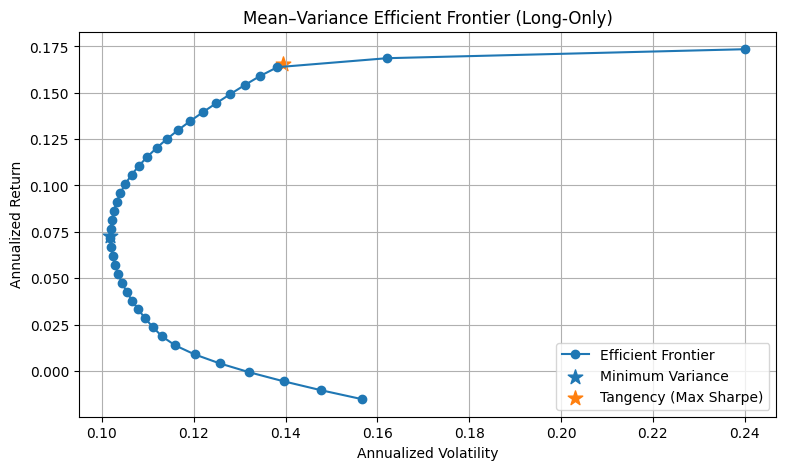

In [18]:
plt.figure(figsize=(9,5))
plt.plot(frontier_vol, frontier_ret, marker="o", linestyle="-", label="Efficient Frontier")

plt.scatter(v_minvar, r_minvar, s=120, marker="*", label="Minimum Variance")
plt.scatter(v_tan, r_tan, s=120, marker="*", label="Tangency (Max Sharpe)")

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Mean–Variance Efficient Frontier (Long-Only)")
plt.legend()
plt.grid(True)
plt.show()


Weights table + interpretation

In [19]:
weights_df = pd.DataFrame({
    "Ticker": tickers,
    "MinVar_Weight": w_minvar,
    "Tangency_Weight": w_tan
}).set_index("Ticker")

weights_df.sort_values("Tangency_Weight", ascending=False)


,MinVar_Weight,Tangency_Weight
Ticker,,
QQQ,0.257907,6.893678e-01
EFA,0.000000,3.106322e-01
TLT,0.218921,2.733942e-16
GLD,0.415121,7.681579e-18
SPY,0.108051,0.000000e+00
IWM,0.000000,0.000000e+00


#Portfolio Analysis
The tangency portfolio allocates more weight to higher expected return assets such as QQQ and SPY, as the optimization seeks to maximize excess return per unit of risk. Although these assets are more volatile, their higher risk premiums improve the portfolio’s Sharpe ratio. In contrast, the minimum-variance portfolio is dominated by low-volatility assets such as TLT, which exhibit low or negative correlation with equities. The covariance structure allows bonds (and to a lesser extent gold) to offset equity risk, resulting in the lowest possible portfolio volatility even at the cost of lower expected returns.

The long-only constraint ( 𝑤≥0 ) restricts the optimizer from taking short positions, which limits the ability to hedge high-volatility or highly correlated assets. As a result, the efficient frontier shifts inward relative to the unconstrained case, reflecting lower achievable Sharpe ratios and reduced diversification efficiency. This constraint produces more realistic portfolios but introduces corner solutions where the optimizer concentrates weights in a small subset of low-risk, low-correlation assets.
